# RF-Squid Array

In [1]:
import scqubits as scq
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
def build_circut_array(n_elements, EJ, EJC, EL, EC):
    # Build the circuit array composend of n_elements identincal rf-SQUIDs and a capacitor in parallel

    # n_elements: number of rf-SQUIDs in the array
    # EJ: Josephson energy of the rf-SQUID
    # EJC: Charging energy of the rf-SQUID
    # EL: Inductive energy of the rf-SQUID
    # EC: Capacitive energy of the capacitor in parallel to the array
    
    # Returns a scqubits the yaml string of the circuit array
    
    rf_array_yaml = """
# rf-SQUID array circuit
branches:"""
    for n in range(n_elements):
        rf_array_yaml = rf_array_yaml + f"""
 - ["JJ", {n+1}, {n+2}, {EJ}, {EJC}]
 - ["L" , {n+1}, {n+2}, {EL}]"""
    rf_array_yaml = rf_array_yaml + f'\n - ["C" , {n_elements+1}, 1, {EC}]'
    return rf_array_yaml

In [3]:
def set_fluxes(qubit, f, n_elements):
    #set fluxes of the qubit

    #qubit: scqubit object
    #f: flux value
    #n_elements: number of elements in the array

    for i in range(n_elements):
        setattr(qubit, f'Φ{i+1}', f)

In [4]:
def set_cutoffs(qubit, cutoff, n_elements):
    #set the cutoff of the Hilbert space of each element in the array
    #since there is no specific reason to have different cutoffs for each element, we set them all to the same value

    #qubit: scqubit object
    #cutoff: the cutoff to set
    #n_elements: the number of elements in the array

    for i in range(n_elements):
        setattr(qubit, f'cutoff_ext_{i+1}', int(cutoff))

In [5]:
def evals_vs_fluxes(qubit,fluxes,n_elements):
    #return the first four eigenvalues of the qubit array vs the flux

    #qubit: scqubit object
    #fluxes: array of fluxes
    #n_elements: number of elements in the array

    E0 = np.ndarray([])
    E1 = np.ndarray([])
    E2 = np.ndarray([])
    E3 = np.ndarray([])
    for f in fluxes:
        set_fluxes(qubit,f, n_elements)
        eigenvals = qubit.eigenvals(evals_count=4)
        E0 = np.append(E0, eigenvals[0])
        E1 = np.append(E1, eigenvals[1])
        E2 = np.append(E2, eigenvals[2])
        E3 = np.append(E3, eigenvals[3])
    return [E0,E1,E2,E3]

In [6]:
def plot_anharmonicity(qubit,fluxes,n_elements):
    #plot the anharmonicity vs the flux

    #qubit: scqubit object
    #fluxes: array of fluxes
    #n_elements: number of elements in the array

    anharm = np.ndarray([])
    for f in fluxes:
        set_fluxes(qubit,f, n_elements)
        anharm = np.append(anharm,qubit.anharmonicity())
    plt.plot(fluxes,anharm[1:])

In [7]:
def compute_anharmonicity(qubit,fluxes, n_elements):
    #compute the anharmonicity vs the flux
    
    #qubit: scqubit object
    #fluxes: array of fluxes
    #n_elements: number of elements in the array
    
    anharm = np.ndarray([])
    for f in fluxes:
        set_fluxes(qubit,f, n_elements)
        anharm = np.append(anharm,qubit.anharmonicity())
    return anharm[1:]

In [8]:
def plot_energies_vs_fluxes(qubit, fluxes, n_elements, substract_ground=False):
    #plot the first four eigenvalues vs the flux
    #if substract_ground is True, the ground state energy is substracted from all the other states

    #qubit: scqubit object
    #fluxes: array of fluxes
    #n_elements: number of elements in the array
    #substract_ground: boolean
    
    evals = evals_vs_fluxes(qubit, fluxes, n_elements)
    if substract_ground:
        plt.plot(fluxes, evals[0][1:] - evals[0][1:])
        plt.plot(fluxes, evals[1][1:] - evals[0][1:])
        plt.plot(fluxes, evals[2][1:] - evals[0][1:])
        plt.plot(fluxes, evals[3][1:] - evals[0][1:])
    else:
        plt.plot(fluxes, evals[0][1:])
        plt.plot(fluxes, evals[1][1:])
        plt.plot(fluxes, evals[2][1:])
        plt.plot(fluxes, evals[3][1:])
    plt.show()

## Single rf-squid Array

In [9]:
n_elements = 1
rf_array_yaml = build_circut_array(n_elements,100,20,500,0.5)
rf_array = scq.Circuit(rf_array_yaml, from_file= False, ext_basis='harmonic' )

In [10]:
print(rf_array_yaml)


# rf-SQUID array circuit
branches:
 - ["JJ", 1, 2, 100, 20]
 - ["L" , 1, 2, 500]
 - ["C" , 2, 1, 0.5]


In [11]:
rf_array.sym_hamiltonian()

<IPython.core.display.Latex object>

In [12]:
rf_array.sym_external_fluxes()

{Φ1: (Branch(L, 1, 2, id_str: 1),
  [Branch(JJ, 1, 2, id_str: 0), Branch(L, 1, 2, id_str: 1)])}

### Eigenenergies vs fluxes

In [13]:
phi_list = np.linspace(-2,2, 500)
evals = evals_vs_fluxes(rf_array, phi_list, n_elements) 

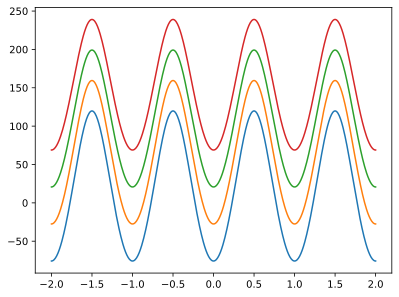

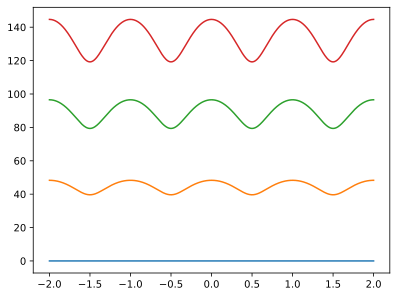

In [14]:
plot_energies_vs_fluxes(rf_array,phi_list, n_elements)
plot_energies_vs_fluxes(rf_array,phi_list, n_elements, substract_ground=True)

### Anharmonicity

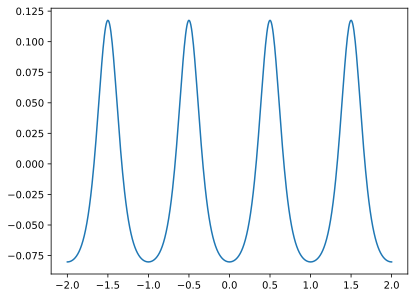

In [15]:
plot_anharmonicity(rf_array,phi_list,n_elements)

### Cutoffs

The default dimension of the Hilbert space for a single rf-SQUID is 30, which means that the total dimension of the Hilbert space for an array of N rf_SQUID will change go as $30^N$. 
This is a huge number and a terrible scaling, and it is not necessary to use such a large Hilbert space to get accurate results. The cutoff parameter allows to reduce the dimension of the Hilbert space by truncating the number of states in the charge basis. The cutoff parameter can be set individually for each rf-SQUID in the array.

In [16]:
cutoffs = np.arange(5, 40, step=1)
diff_zero = []
diff_pi = []

set_fluxes(rf_array, 0, 1)

for cutoff in cutoffs:
    set_cutoffs(rf_array, cutoff ,1)
    evals_zero = rf_array.eigenvals(evals_count=2)
    diff_zero = np.append(diff_zero,evals_zero[1]-evals_zero[0])

set_fluxes(rf_array, 0.5, 1)

for cutoff in cutoffs:
    set_cutoffs(rf_array, cutoff ,1)
    evals_pi = rf_array.eigenvals(evals_count=2)
    diff_pi = np.append(diff_pi,evals_pi[1]-evals_pi[0])

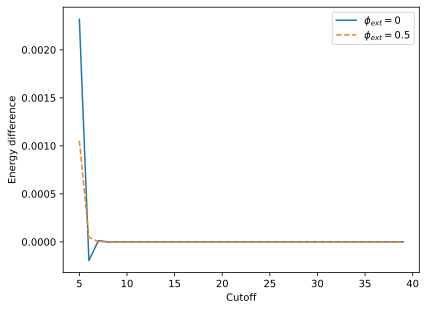

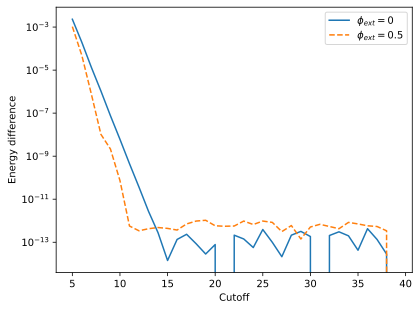

In [17]:
plt.plot(cutoffs,diff_zero-diff_zero[-1], label= r'$\phi_{ext} = 0$')
plt.plot(cutoffs,diff_pi-diff_pi[-1],'--', label= r'$\phi_{ext} = 0.5$')
plt.xlabel('Cutoff')
plt.ylabel('Energy difference')
plt.legend()
plt.show()

plt.semilogy(cutoffs, abs(diff_zero-diff_zero[-1]), label= r'$\phi_{ext} = 0$')
plt.semilogy(cutoffs, abs(diff_pi-diff_pi[-1]),'--', label= r'$\phi_{ext} = 0.5$')
plt.xlabel('Cutoff')
plt.ylabel('Energy difference')
plt.legend()
plt.show()

In [18]:
rf_array_yaml = build_circut_array(1,100,20,500,0.5)
rf_array = scq.Circuit(rf_array_yaml, from_file= False, ext_basis='harmonic' )

### Convergence time vs parameters

In [19]:
# temps de convergence en fonction de EJ, EL pour un rf-SQUID à phi = 0 et phi = 0.5
import time
def measure_convergence_time(qubit):
    start_time = time.time()

    qubit.eigenvals(evals_count=4)

    convergence_time = time.time() - start_time
    return convergence_time

In [24]:
EJ_values = np.linspace(20, 200, 100)
EL_values = np.linspace(100, 1000, 100)

convergence_times = np.zeros((len(EJ_values), len(EL_values)))


for i, EJ in enumerate(EJ_values):
    for j, EL in enumerate(EL_values):
        rf_array_yaml = build_circut_array(1,EJ,20,EL,0.5) #not efficient, but it works
        rf_array = scq.Circuit(rf_array_yaml, from_file= False, ext_basis='harmonic' )
        convergence_times[i, j] = measure_convergence_time(rf_array)

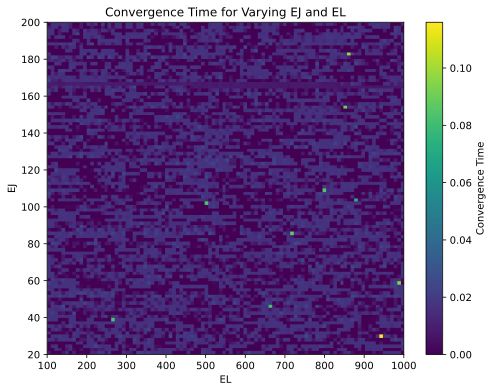

In [25]:
plt.figure(figsize=(8, 6))
plt.imshow(convergence_times, extent=[min(EL_values), max(EL_values), min(EJ_values), max(EJ_values)],
           aspect='auto', origin='lower')
plt.colorbar(label='Convergence Time')
plt.xlabel('EL')
plt.ylabel('EJ')
plt.title('Convergence Time for Varying EJ and EL')
plt.show()

### Convergence vs parameters

In [20]:
def energy_difference_vs_cutoff(qubit, cutoffs):
    #compute the energy difference between the first two eigenvalues vs the cutoff

    #qubit: scqubit object
    #cutoffs: array of cutoffs
    #fluxes: array of fluxes

    diff_zero = np.ndarray([])
    diff_pi = np.ndarray([])
    for cutoff in cutoffs:
        set_cutoffs(qubit, cutoff, 1)
        set_fluxes(qubit, 0, 1)
        evals_zero = qubit.eigenvals(evals_count=2)
        diff_zero = np.append(diff_zero, evals_zero[1]-evals_zero[0])
        set_fluxes(qubit, 0.5, 1)
        evals_pi = qubit.eigenvals(evals_count=2)
        diff_pi = np.append(diff_pi, evals_pi[1]-evals_pi[0])
    return [diff_zero, diff_pi]

#### Changing $E_J$

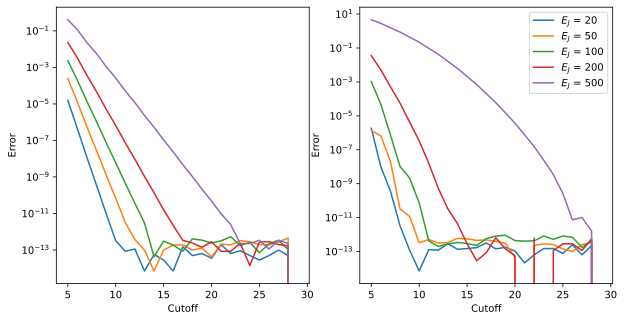

In [22]:
EJS_list = [20, 50, 100, 200, 500]
cutoffs = np.arange(5, 30, step=1)
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
for EJ_el in EJS_list:
    rf_array_yaml = build_circut_array(1,EJ_el,20,500,0.5)
    rf_array = scq.Circuit(rf_array_yaml, from_file= False, ext_basis='harmonic' )
    diff_zero, diff_pi = energy_difference_vs_cutoff(rf_array, cutoffs)
    ax[0].semilogy(cutoffs, abs(diff_zero[1:]-diff_zero[-1]), label= f'$E_J$ = {EJ_el}')
    ax[1].semilogy(cutoffs, abs(diff_pi[1:]-diff_pi[-1]), label= f'$E_J$ = {EJ_el}')
ax[0].set_xlabel('Cutoff')
ax[0].set_ylabel('Error')
ax[1].set_xlabel('Cutoff')
ax[1].set_ylabel('Error')
plt.legend()

#### Changing $E_L$

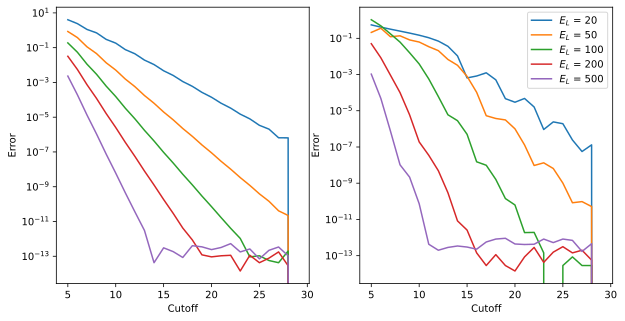

In [24]:
ELS_list = [100, 250, 500, 1000, 2000]
cutoffs = np.arange(5, 30, step=1)
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
for EL_el in EJS_list:
    rf_array_yaml = build_circut_array(1,100,20,EL_el,0.5)
    rf_array = scq.Circuit(rf_array_yaml, from_file= False, ext_basis='harmonic' )
    diff_zero, diff_pi = energy_difference_vs_cutoff(rf_array, cutoffs)
    ax[0].semilogy(cutoffs, abs(diff_zero[1:]-diff_zero[-1]), label= f'$E_L$ = {EL_el}')
    ax[1].semilogy(cutoffs, abs(diff_pi[1:]-diff_pi[-1]), label= f'$E_L$ = {EL_el}')
ax[0].set_xlabel('Cutoff')
ax[0].set_ylabel('Error')
ax[1].set_xlabel('Cutoff')
ax[1].set_ylabel('Error')
plt.legend()

### Faster convergence
We set the ratio $E_L/E_J = 50$ keeping $E_L/E_C \gg 1$ and $E_J/E_C \gg 1$.

In [26]:
#Parameters 
hbar = sp.constants.hbar
h = sp.constants.h
e = sp.constants.e
phi0 = hbar/(2*e)

ECJ = 20
EJ = 50 
EL = 2500
EC = 0.5
n_elements = 1

In [11]:
print(h)

6.62607015e-34


In [12]:
rf_array_yaml = build_circut_array(n_elements,EJ,ECJ,EL,EC)
rf_array = scq.Circuit(rf_array_yaml, from_file= False, ext_basis='harmonic' )

In [32]:

cutoffs = np.arange(5, 40, step=1)
diff_zero = []
diff_pi = []

set_fluxes(rf_array, 0, 1)

for cutoff in cutoffs:
    set_cutoffs(rf_array, cutoff ,1)
    evals_zero = rf_array.eigenvals(evals_count=2)
    diff_zero = np.append(diff_zero,evals_zero[1]-evals_zero[0])

set_fluxes(rf_array, 0.5, 1)

for cutoff in cutoffs:
    set_cutoffs(rf_array, cutoff ,1)
    evals_pi = rf_array.eigenvals(evals_count=2)
    diff_pi = np.append(diff_pi,evals_pi[1]-evals_pi[0])

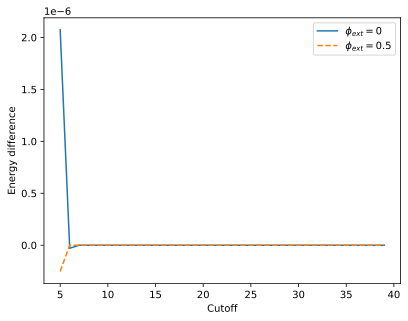

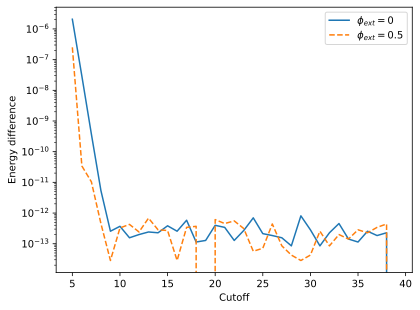

In [33]:
plt.plot(cutoffs,diff_zero-diff_zero[-1], label= r'$\phi_{ext} = 0$')
plt.plot(cutoffs,diff_pi-diff_pi[-1],'--', label= r'$\phi_{ext} = 0.5$')
plt.xlabel('Cutoff')
plt.ylabel('Energy difference')
plt.legend()
plt.show()

plt.semilogy(cutoffs, abs(diff_zero-diff_zero[-1]), label= r'$\phi_{ext} = 0$')
plt.semilogy(cutoffs, abs(diff_pi-diff_pi[-1]),'--', label= r'$\phi_{ext} = 0.5$')
plt.xlabel('Cutoff')
plt.ylabel('Energy difference')
plt.legend()
plt.show()

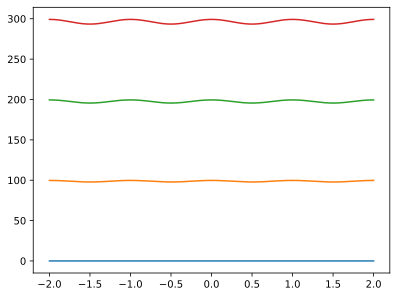

In [34]:
plot_energies_vs_fluxes(rf_array,phi_list,n_elements,substract_ground=True)

## Double rf-Squid array

In [35]:
n_elements = 2
rf_array_yaml = build_circut_array(n_elements,EJ,ECJ,EL,EC)
rf_array = scq.Circuit(rf_array_yaml, from_file= False, ext_basis='harmonic' )
set_cutoffs(rf_array, 15 ,n_elements)

In [36]:
phi_list = np.linspace(-2,2, 100)

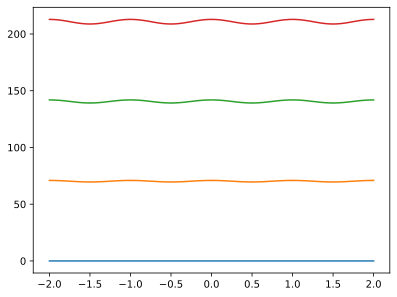

In [37]:
plot_energies_vs_fluxes(rf_array,phi_list,n_elements,substract_ground=True)

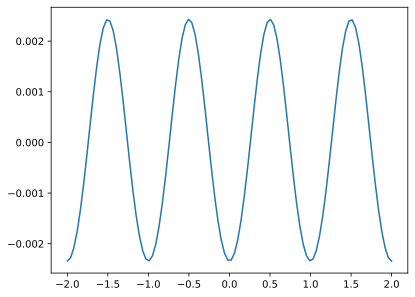

In [38]:
plot_anharmonicity(rf_array,phi_list, n_elements)

In [39]:
cutoffs = np.arange(5, 30, step=1)
diff_zero = []
diff_pi = []

set_fluxes(rf_array, 0 , 2)

for cutoff in cutoffs:
    set_cutoffs(rf_array, cutoff ,2)
    evals_zero = rf_array.eigenvals(evals_count=2)
    diff_zero = np.append(diff_zero,evals_zero[1]-evals_zero[0])

set_fluxes(rf_array, 0.5, 2)

for cutoff in cutoffs:
    set_cutoffs(rf_array, cutoff ,2)
    evals_pi = rf_array.eigenvals(evals_count=2)
    diff_pi = np.append(diff_pi,evals_pi[1]-evals_pi[0])

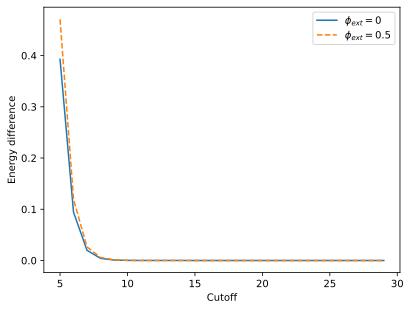

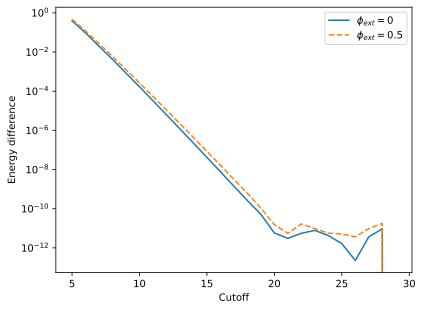

In [40]:
plt.plot(cutoffs,diff_zero-diff_zero[-1], label= r'$\phi_{ext} = 0$')
plt.plot(cutoffs,diff_pi-diff_pi[-1],'--', label= r'$\phi_{ext} = 0.5$')
plt.xlabel('Cutoff')
plt.ylabel('Energy difference')
plt.legend()
plt.show()

plt.semilogy(cutoffs, abs(diff_zero-diff_zero[-1]), label= r'$\phi_{ext} = 0$')
plt.semilogy(cutoffs, abs(diff_pi-diff_pi[-1]),'--', label= r'$\phi_{ext} = 0.5$')
plt.xlabel('Cutoff')
plt.ylabel('Energy difference')
plt.legend()
plt.show()  

## 3 elements

In [27]:
n_elements = 3
rf_array_yaml = build_circut_array(n_elements,EJ,ECJ,EL,EC)
rf_array = scq.Circuit(rf_array_yaml, from_file= False, ext_basis='harmonic' )
set_cutoffs(rf_array, 15 ,n_elements)

In [28]:
cutoffs = np.arange(5, 30, step=1)
diff_zero = []
diff_pi = []

set_fluxes(rf_array, 0 , 2)

for cutoff in cutoffs:
    set_cutoffs(rf_array, cutoff ,2)
    evals_zero = rf_array.eigenvals(evals_count=2)
    diff_zero = np.append(diff_zero,evals_zero[1]-evals_zero[0])

set_fluxes(rf_array, 0.5, 2)

for cutoff in cutoffs:
    set_cutoffs(rf_array, cutoff ,2)
    evals_pi = rf_array.eigenvals(evals_count=2)
    diff_pi = np.append(diff_pi,evals_pi[1]-evals_pi[0])

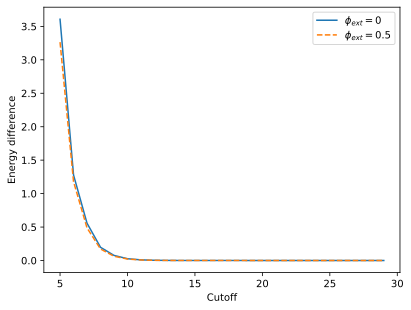

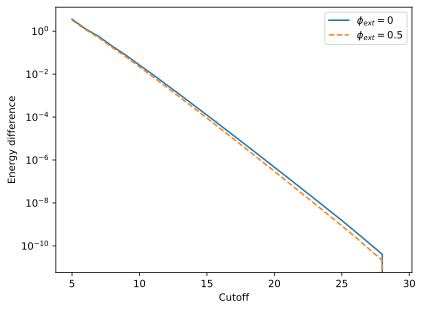

In [29]:
plt.plot(cutoffs,diff_zero-diff_zero[-1], label= r'$\phi_{ext} = 0$')
plt.plot(cutoffs,diff_pi-diff_pi[-1],'--', label= r'$\phi_{ext} = 0.5$')
plt.xlabel('Cutoff')
plt.ylabel('Energy difference')
plt.legend()
plt.show()

plt.semilogy(cutoffs, abs(diff_zero-diff_zero[-1]), label= r'$\phi_{ext} = 0$')
plt.semilogy(cutoffs, abs(diff_pi-diff_pi[-1]),'--', label= r'$\phi_{ext} = 0.5$')
plt.xlabel('Cutoff')
plt.ylabel('Energy difference')
plt.legend()
plt.show()  

## 4 elements

In [ ]:
n_elements = 4
rf_array_yaml = build_circut_array(n_elements,EJ,ECJ,EL,EC)
rf_array = scq.Circuit(rf_array_yaml, from_file= False, ext_basis='harmonic' )
set_cutoffs(rf_array, 15 ,n_elements)

In [ ]:
cutoffs = np.arange(5, 30, step=1)
diff_zero = []
diff_pi = []

set_fluxes(rf_array, 0 , 2)

for cutoff in cutoffs:
    set_cutoffs(rf_array, cutoff ,2)
    evals_zero = rf_array.eigenvals(evals_count=2)
    diff_zero = np.append(diff_zero,evals_zero[1]-evals_zero[0])

set_fluxes(rf_array, 0.5, 2)

for cutoff in cutoffs:
    set_cutoffs(rf_array, cutoff ,2)
    evals_pi = rf_array.eigenvals(evals_count=2)
    diff_pi = np.append(diff_pi,evals_pi[1]-evals_pi[0])

## 5 rf-Squid array

In [41]:
n_elements = 5
rf_array_yaml = build_circut_array(n_elements,EJ,ECJ,EL,EC)
rf_array = scq.Circuit(rf_array_yaml, from_file= False, ext_basis='harmonic' )
set_cutoffs(rf_array, 5 ,n_elements)

In [42]:
cutoffs = np.arange(2, 10, step=1)
diff_zero = []
diff_pi = []

set_fluxes(rf_array, 0 , 5)

for cutoff in cutoffs:
    set_cutoffs(rf_array, cutoff ,5)
    evals_zero = rf_array.eigenvals(evals_count=2)
    diff_zero = np.append(diff_zero,evals_zero[1]-evals_zero[0])

set_fluxes(rf_array, 0.5, 5)

for cutoff in cutoffs:
    set_cutoffs(rf_array, cutoff ,5)
    evals_pi = rf_array.eigenvals(evals_count=2)
    diff_pi = np.append(diff_pi,evals_pi[1]-evals_pi[0])

In [43]:
np.savez('cutoffs.npz', cutoffs=cutoffs, diff_zero=diff_zero, diff_pi=diff_pi, allow_pickle=True)

In [44]:
file  = np.load('cutoffs.npz', allow_pickle=True)
cutoffs = file['cutoffs']
diff_zero = file['diff_zero']
diff_pi = file['diff_pi']

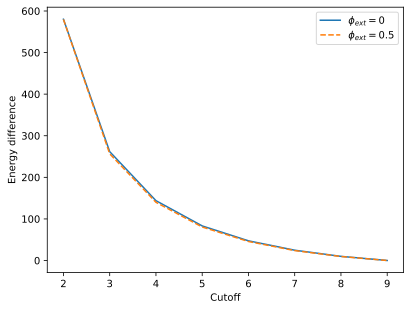

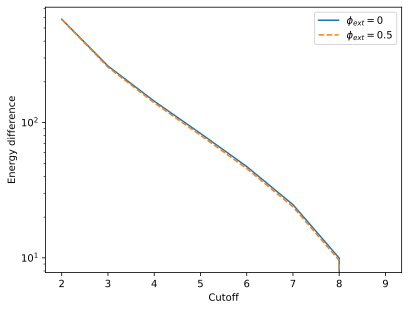

In [45]:
plt.plot(cutoffs,diff_zero-diff_zero[-1], label= r'$\phi_{ext} = 0$')
plt.plot(cutoffs,diff_pi-diff_pi[-1],'--', label= r'$\phi_{ext} = 0.5$')
plt.xlabel('Cutoff')
plt.ylabel('Energy difference')
plt.legend()
plt.show()

plt.semilogy(cutoffs, abs(diff_zero-diff_zero[-1]), label= r'$\phi_{ext} = 0$')
plt.semilogy(cutoffs, abs(diff_pi-diff_pi[-1]),'--', label= r'$\phi_{ext} = 0.5$')
plt.xlabel('Cutoff')
plt.ylabel('Energy difference')
plt.legend()
plt.show()

In [46]:
#phi_list = np.linspace(-2,2, 100)

In [47]:
#plot_energies_vs_fluxes(rf_array,phi_list, n_elements, substract_ground=True)

In [48]:
#plot_anharmonicity(rf_array,phi_list, n_elements)

## Scaling behaviour

freq at phi=0 as a function of n, should scale as 1/sqrt(n)

In [17]:
def compute_resonant_freq(n, phi):
    #implement flux dependency in EJ
    C_J = e**2/(2*ECJ*h)
    C = e**2/(2*EC*h)
    L_J = phi0**2/(EJ*np.cos(phi)*h)
    L = phi0**2/(EL*h)
    return 1/(2*np.pi * np.sqrt(n*L*L_J/(L+L_J)*(C_J/n + C)))

cutoff study

find cutoff for one flux (plot energy E_01 and look for convergence)
Restrict to one period and two energy levels , for large N look only at phi =0 and phi = pi (omega vs N).
Same for anharm.

In [14]:
def omegavsN(N,EJ, ECJ, EL, EC):
    omega_zero_flux = np.ndarray([])
    omega_pi_flux = np.ndarray([])
    omega_zero_analytic = np.ndarray([])
    omega_pi_analytic = np.ndarray([])
    #compute the resonant freq (transition 01) at flux 0 and pi with compute eigenvaluesvs flux
    for n in N-1:
        rf_array_yaml = build_circut_array(int(n+1),EJ, ECJ, EL, EC)
        rf_array = scq.Circuit(rf_array_yaml, from_file = False, ext_basis='harmonic' )
        set_cutoffs(rf_array, 15, int(n+1))
        set_fluxes(rf_array,0,int(n+1))
        evals_zero = rf_array.eigenvals(evals_count=2)
        omega_zero_flux = np.append(omega_zero_flux, evals_zero[1]-evals_zero[0])
        omega_zero_analytic = np.append(omega_zero_analytic, compute_resonant_freq(n+1, 0))

        set_fluxes(rf_array,0.5,int(n+1))
        evals_pi = rf_array.eigenvals(evals_count=2)
        omega_pi_flux = np.append(omega_pi_flux, evals_pi[1]-evals_pi[0])
        omega_pi_analytic = np.append(omega_pi_analytic, compute_resonant_freq(n+1, 0.5))
    return [omega_zero_flux, omega_pi_analytic, omega_pi_flux, omega_pi_analytic]

In [15]:
omega_zero_analytic = np.ndarray([])
omega_zero_flux = np.ndarray([])
rf_array_yaml = build_circut_array(1,EJ, ECJ, EL, EC)
rf_array = scq.Circuit(rf_array_yaml, from_file = False, ext_basis='harmonic' )
evals_zero = rf_array.eigenvals(evals_count=2)
omega_zero_flux = np.append(omega_zero_flux, evals_zero[1]-evals_zero[0])
omega_zero_analytic = np.append(omega_zero_analytic, compute_resonant_freq(1, 0))

In [18]:
print(omega_zero_analytic)
print(evals_zero)
print(evals_zero[1]-evals_zero[0])
compute_resonant_freq(1, 0)

[3.90243902e+00 6.26784173e+08]
[-0.12448399 99.62179541]
99.74627940283908


99.75579939128913

In [53]:
def anharmonicityvsN(N, EJ, EJC, EL, EC):
    anhram_zero_flux = np.ndarray([])
    anharm_pi_flux = np.ndarray([])
    for n in N-1:
        rf_array_yaml = build_circut_array(int(n+1), EJ, EJC, EL, EC)
        rf_array = scq.Circuit(rf_array_yaml, from_file= False, ext_basis='harmonic' )
        set_cutoffs(rf_array, 15, int(n+1))
        set_fluxes(rf_array, 0, int(n+1))
        anhram_zero_flux = np.append(anhram_zero_flux, rf_array.anharmonicity())
        set_fluxes(rf_array, 0.5, int(n+1))
        anharm_pi_flux = np.append(anharm_pi_flux, rf_array.anharmonicity())
    return [anhram_zero_flux, anharm_pi_flux]

In [54]:
N = np.linspace(1,3, 3)
N

array([1., 2., 3.])

In [55]:
N = np.linspace(1,4, 4)
omega_res = omegavsN(N, EJ, ECJ, EL, EC)

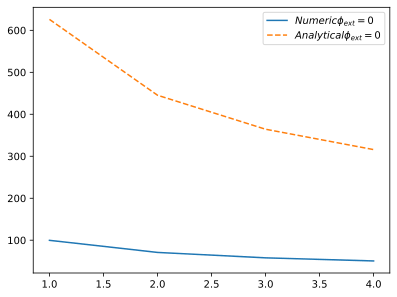

In [56]:
plt.plot(N, omega_res[0][1:], label= r'Numeric $\phi_{ext} = 0$')
plt.plot(N, omega_res[1][1:], '--', label= r'Analytical $\phi_{ext} = 0$')
plt.legend()


In [57]:
N = np.linspace(1,4, 4)
anharm_vs_N = anharmonicityvsN(N, EJ, ECJ, EL, EC)

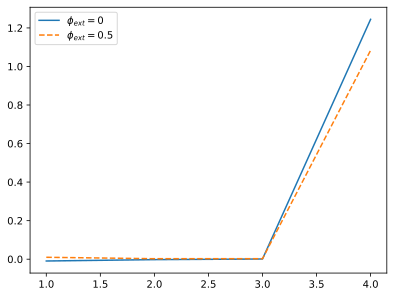

In [58]:
plt.plot(N, anharm_vs_N[0][1:],  label= r'$\phi_{ext} = 0$')
plt.plot(N, anharm_vs_N[1][1:], '--', label= r'$\phi_{ext} = 0.5$')
plt.legend()

### Convergence time vs parameters

### QUTIP Approach

In [59]:
import qutip as qt

rf_array_yaml = build_circut_array(1,100,20,500,0.5)
rf_array = scq.Circuit(rf_array_yaml, from_file= False, ext_basis='harmonic' )

In [60]:
hilbertspace = scq.HilbertSpace([rf_array])

AttributeError: 'NoneType' object has no attribute 'item'

In [ ]:
tmon1 = scq.Transmon(
    EJ=40.0,
    EC=0.2,
    ng=0.3,
    ncut=40,
    truncated_dim=4     # after diagonalization, we will keep levels 0, 1, 2, and 3
)

hilbertspace = scq.HilbertSpace([tmon1, tmon1])